In [1]:
# Im adding the heart rate into the features extracted using a heuristic function based on these rules 

# Pitch (F0) — higher pitch means higher heart rate
# Energy — louder speech means higher heart rate
# Speaking rate — faster speech means higher heart rate

In [10]:
import numpy as np
import pandas as pd

In [11]:
df = pd.read_csv("speech_features.csv")

In [12]:
pitch_max = np.percentile(df['pitch_mean'], 95)
energy_max = np.percentile(df['energy'], 95)
rate_max = np.percentile(df['speaking_rate'], 95)

print(f"pitch_max ~ {pitch_max:.1f}, energy_max ~ {energy_max:.1f}, rate_max ~ {rate_max:.1f}")

pitch_max ~ 1912.8, energy_max ~ 30.1, rate_max ~ 10.9


In [14]:

def simulate_heart_rate(row, pitch_max=1912.8, energy_max=30.1, rate_max=10.9, depth_max=1000):
    gender = row.get('gender', 'unknown').lower()

    # Set resting HR based on gender
    if gender == 'female':
        resting_hr = 58  # Slightly higher resting HR on average
        pitch_scaling = 6.5
        energy_scaling = 5.5
        rate_scaling = 8
        depth_scaling = 4.5
        interaction_scaling = 3.2
        mfcc_scaling = 3.5
    elif gender == 'male':
        resting_hr = 52
        pitch_scaling = 6
        energy_scaling = 5
        rate_scaling = 7
        depth_scaling = 5
        interaction_scaling = 3
        mfcc_scaling = 3
    else:  # fallback
        resting_hr = 55
        pitch_scaling = 6.2
        energy_scaling = 5.2
        rate_scaling = 7.5
        depth_scaling = 4.7
        interaction_scaling = 3.1
        mfcc_scaling = 3.2

    # Normalize inputs
    mfcc_values = np.array([row[f'mfcc_{i}'] for i in range(1, 14)])
    mfcc_norm = np.clip(np.linalg.norm(mfcc_values) / 100, 0, 1)
    pitch_norm = np.clip(row['pitch_mean'] / pitch_max, 0, 1)
    energy_norm = np.clip(row['energy'] / energy_max, 0, 1)
    rate_norm = np.clip(row['speaking_rate'] / rate_max, 0, 1)
    depth_norm = np.clip(row['pitch_depth'] / depth_max, 0, 1)

    # Effects
    pitch_effect = pitch_scaling * np.tanh(2 * pitch_norm)
    energy_effect = energy_scaling * (energy_norm ** 1.3)
    rate_effect = rate_scaling * np.sqrt(rate_norm)
    depth_effect = depth_scaling * (depth_norm ** 0.7)
    interaction = interaction_scaling * pitch_norm * rate_norm
    mfcc_effect = mfcc_scaling * (mfcc_norm ** 1.2)

    # Final HR with noise
    hr = resting_hr + pitch_effect + energy_effect + rate_effect + depth_effect + interaction + mfcc_effect
    noise = np.random.normal(0, 5)
    hr += noise

    # Clip for realism
    hr = np.clip(hr, 50, 110)

    return hr


In [15]:
df["simulated_hr"] = df.apply(simulate_heart_rate, axis=1)

df.to_csv("speech_features_with_hr.csv", index=False)

print("done.")

done.


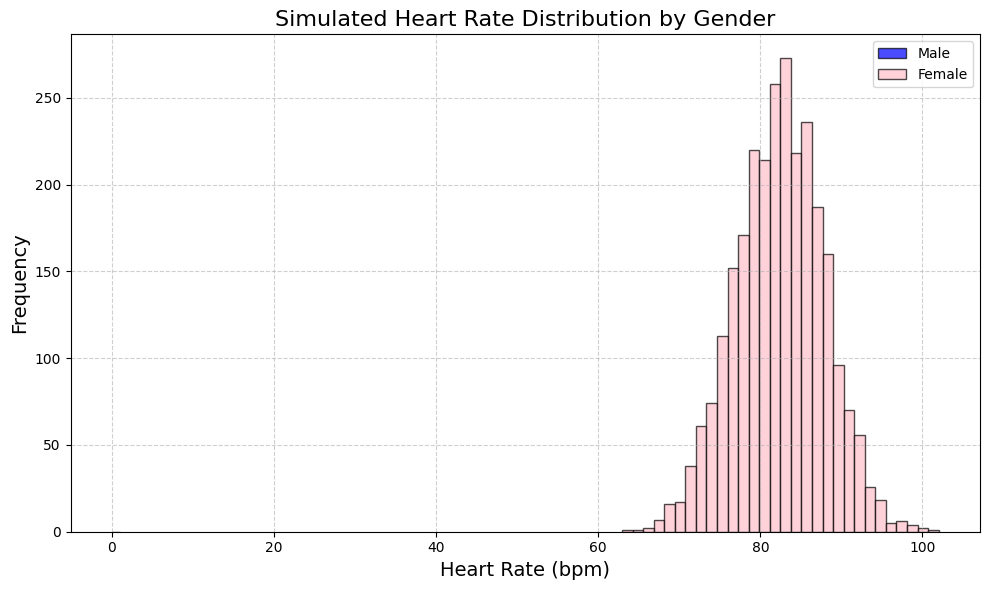

In [16]:
import matplotlib.pyplot as plt

# Filter by gender
male_hr = df[df['gender'] == 'male']['simulated_hr']
female_hr = df[df['gender'] == 'female']['simulated_hr']

# Plot
plt.figure(figsize=(10, 6))
plt.hist(male_hr, bins=30, alpha=0.7, label='Male', color='blue', edgecolor='black')
plt.hist(female_hr, bins=30, alpha=0.7, label='Female', color='pink', edgecolor='black')

plt.title("Simulated Heart Rate Distribution by Gender", fontsize=16)
plt.xlabel("Heart Rate (bpm)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
